#  Pulsar Simulation

## Custom pulsar simuation.  Random gaussian noise with gaussian time profile pulse is dispersed.

In [1]:
## Sim Pulsar 12ghz sampling -> downsample
%matplotlib notebook
import numpy as np
from matplotlib.pyplot import *

In [2]:
### gaussian pulse, 0.4ms width, 5ms period.  dm of 15? pc/cm^3. 0.15 second sim?
Fbw = 400e6  #total bandwidth wanted
Flo = 1.4e9 #Center frequency
fs_rf = 12e9 # Frequency running simulation at.

In [3]:
t = np.linspace(-0.0025,0.0025, 0.005*fs_rf) #create a time index, in seconds, 5ms total, center zero for ease.  

/Users/kbandura/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [4]:
# pulsar is basically a pulsed random noise signal.
l = len(t)
mu, sigma = 0, 1
s = np.random.normal(mu, sigma, l)  # create random noise signal

In [5]:
#turn random signal into pulsed.  
#gaussian profile  4ms width
s = np.exp(-t**2/(2*0.0004**2))*s

<IPython.core.display.Javascript object>


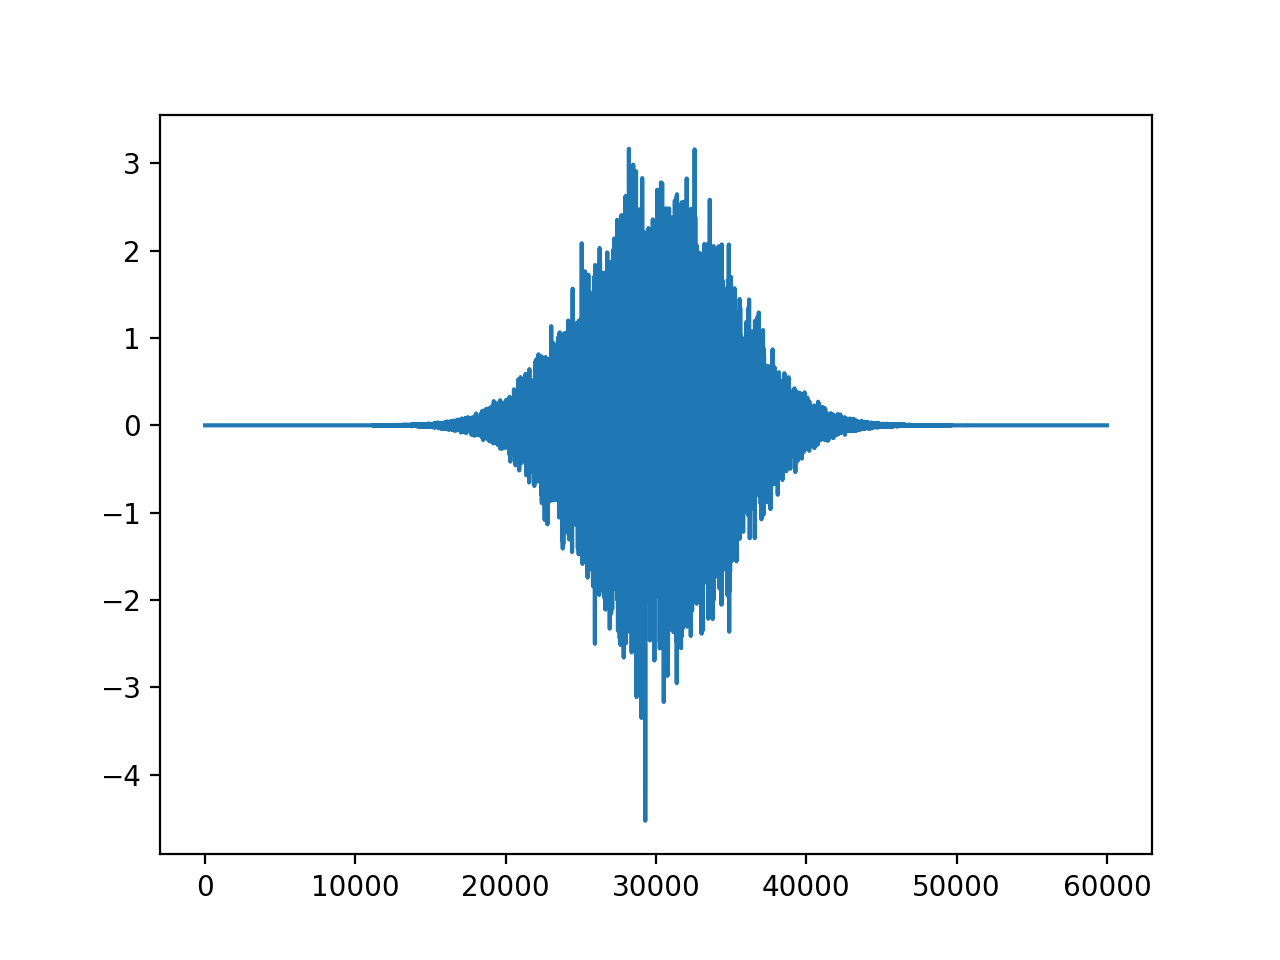

In [6]:
figure()
plot(s[::1000])

In [7]:
# freq data
fpulse = np.fft.fft(s)

<IPython.core.display.Javascript object>


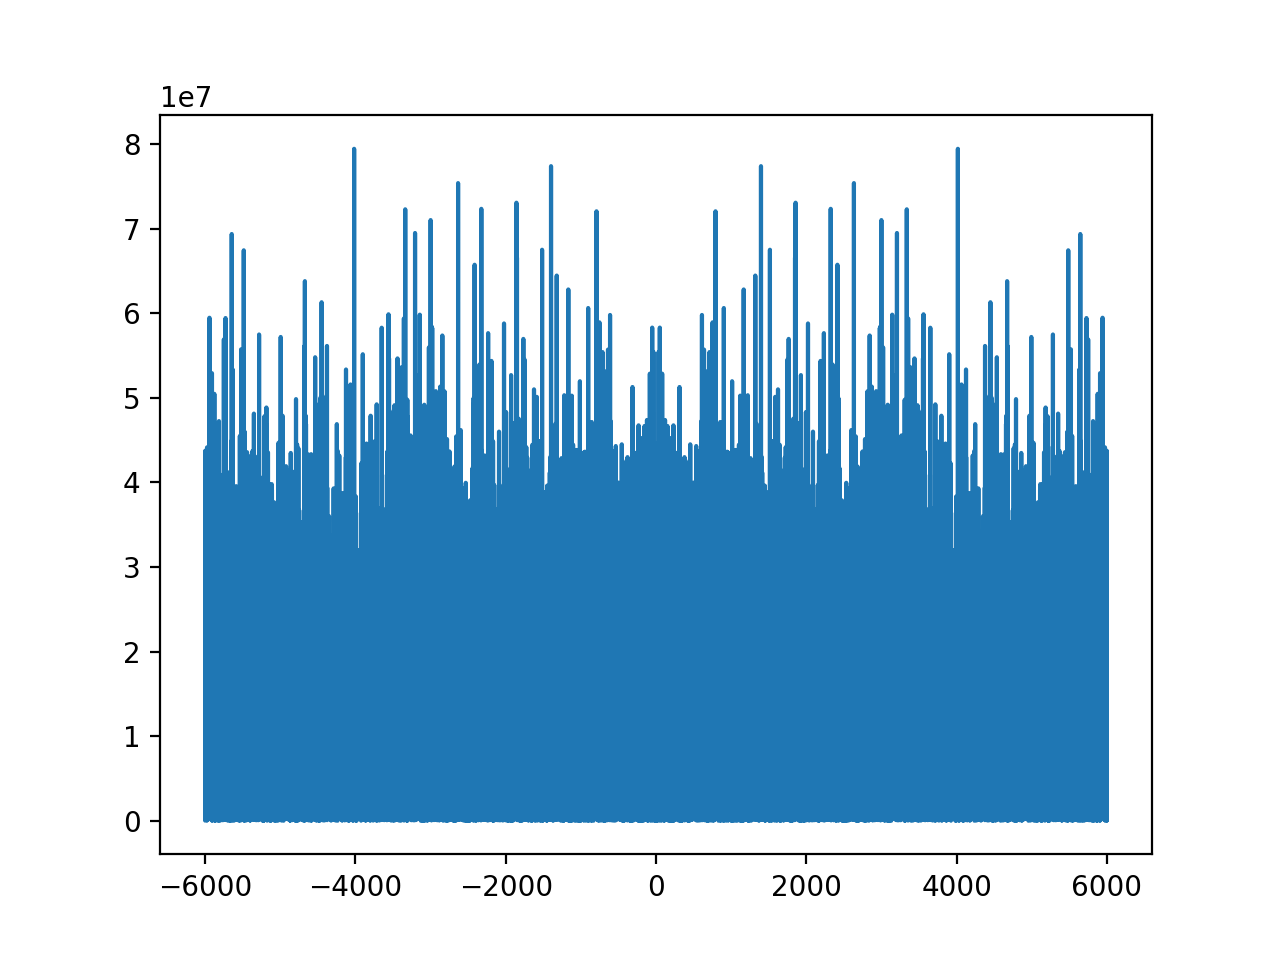

In [8]:
# should look like nice broadband noise.  
freq = np.fft.fftfreq(l,1.0/(fs_rf/1e6))
figure()
plot(freq[::1000], np.abs(fpulse[::1000])**2)

In [9]:
#bandpass the pulse to receiver band.
Fbw = 400e6  #bandwidth wanted
Flo = 1.4e9 #Center frequency
fs_rf = 12e9 # Frequency running simulation at.
highpass_freq = Flo-Fbw/2.0
highpass_index1 = int(highpass_freq/(fs_rf/2)*l/2)
highpass_index2 = l - highpass_index1
fpulse[:highpass_index1] = 0
fpulse[highpass_index2:] = 0
nyquest_index = int(l/2)
lowpass_freq = Flo+Fbw/2.0
lowpass_index1 = int(lowpass_freq/(fs_rf/2)*l/2)
lowpass_index2 = l - lowpass_index1
fpulse[lowpass_index1:nyquest_index] = 0
fpulse[nyquest_index:lowpass_index2] = 0

In [10]:
freq = np.fft.fftfreq(l,1.0/(fs_rf/1e6))  #megahertz frequencies.
signal_lo_complex = np.exp(-2.0j*np.pi * Flo/fs_rf * np.arange(l) )  #create mixing signal

<IPython.core.display.Javascript object>


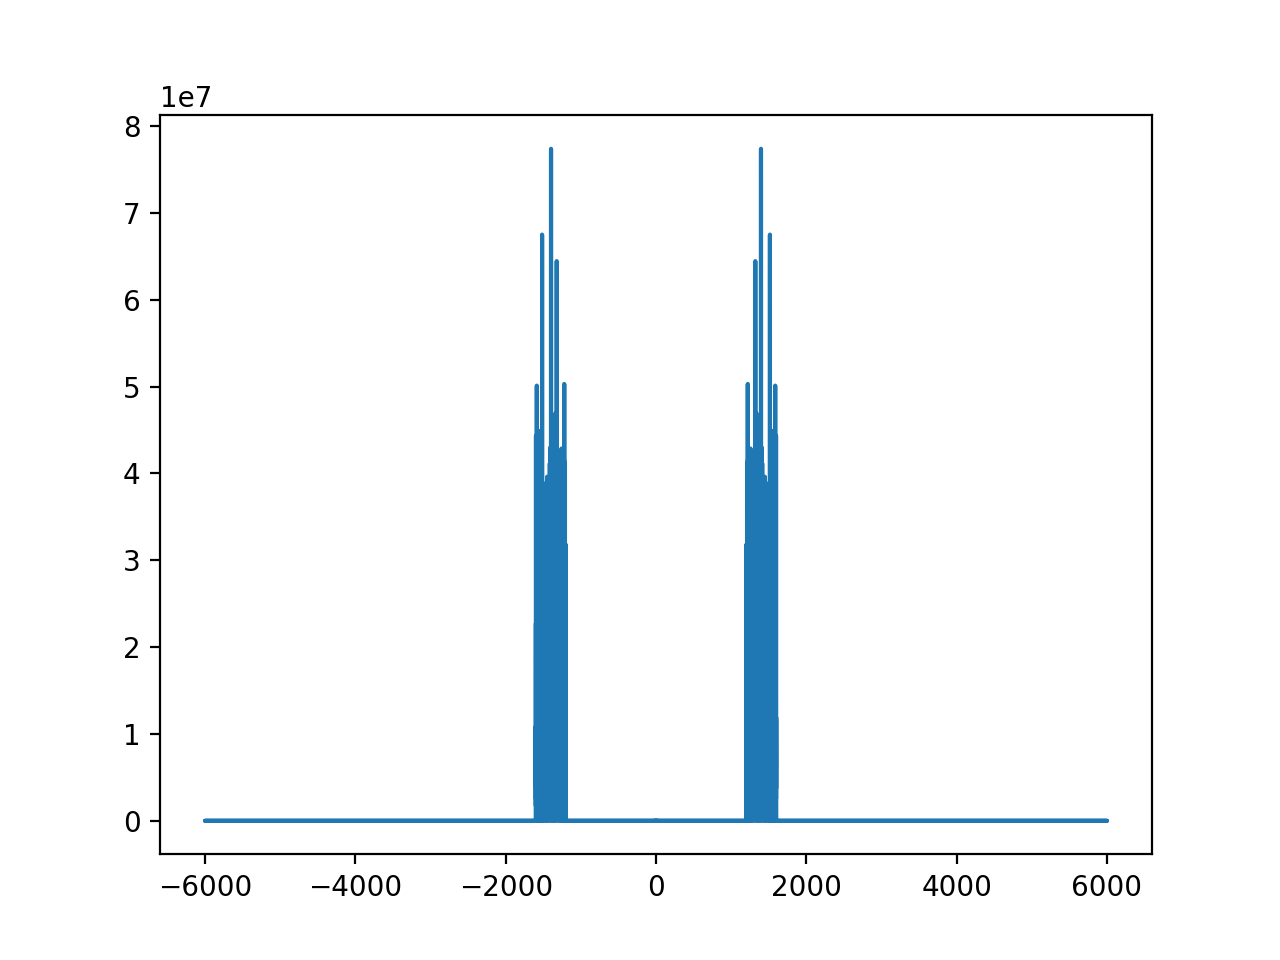

In [11]:
# now band limited,  Real signal.  
figure()
plot(freq[::1000], np.abs(fpulse[::1000])**2)

In [12]:
band_limited_s = np.fft.ifft(fpulse)

<IPython.core.display.Javascript object>


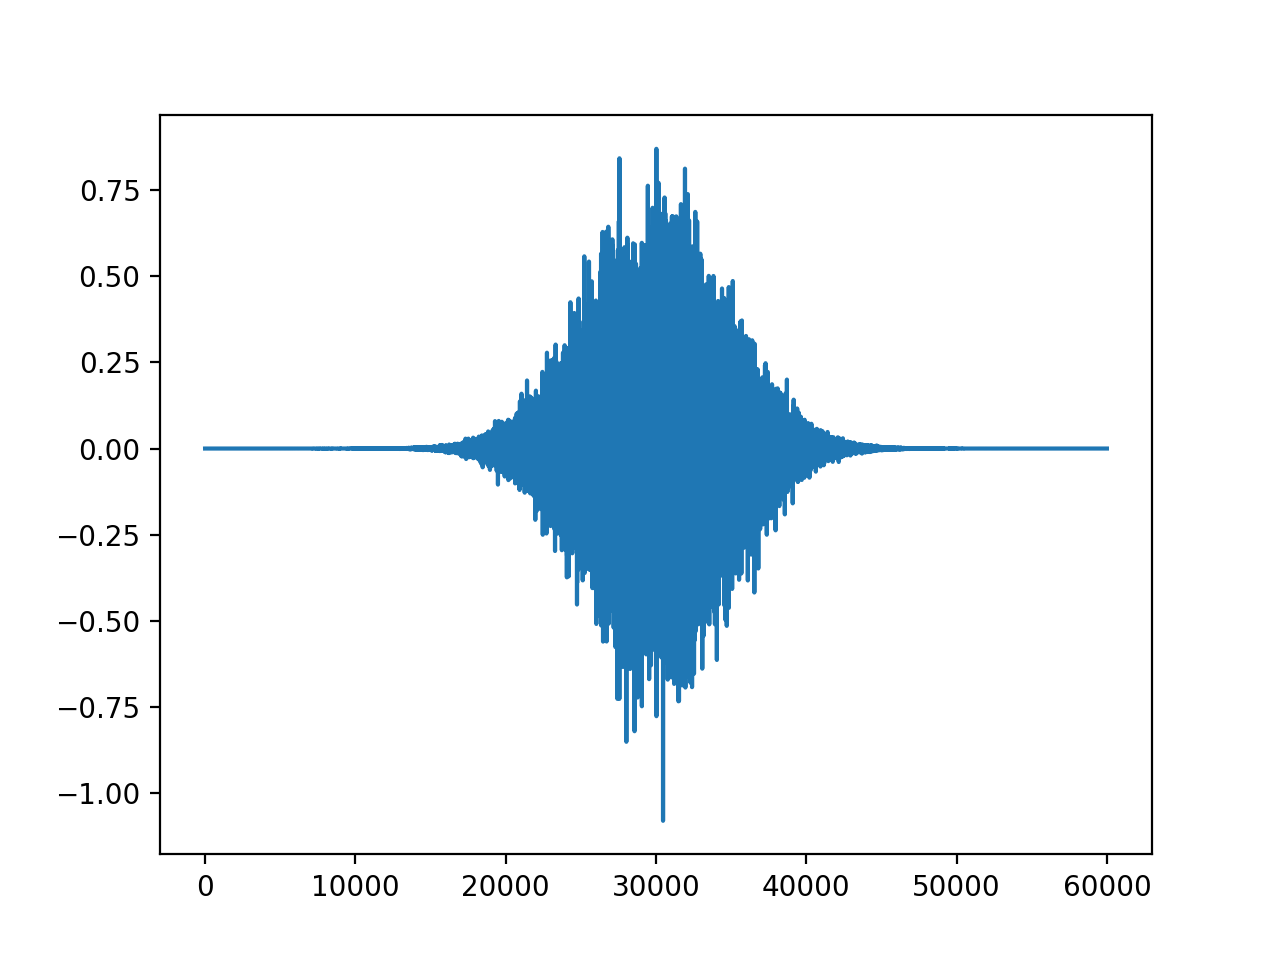

/Users/kbandura/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [13]:
# show band limited pulse.  Still basically the same.  
figure()
plot(band_limited_s[::1000])

In [14]:
#mix down and filter, so that have I Q data for bandwidth
mixed_down_s = band_limited_s*signal_lo_complex
N_cutoff = int(Fbw/2/fs_rf*l)
fmixed = np.fft.fft(mixed_down_s)
fmixed[N_cutoff:-N_cutoff] = 0.0
filtered_mixed_down_s = np.fft.ifft(fmixed)
#Downsample so that is...
downsampled_filtered_mixed_down_s = filtered_mixed_down_s[::int(fs_rf/(Fbw))]
#complex sampled at 400MHz instead of 12GHz

<IPython.core.display.Javascript object>


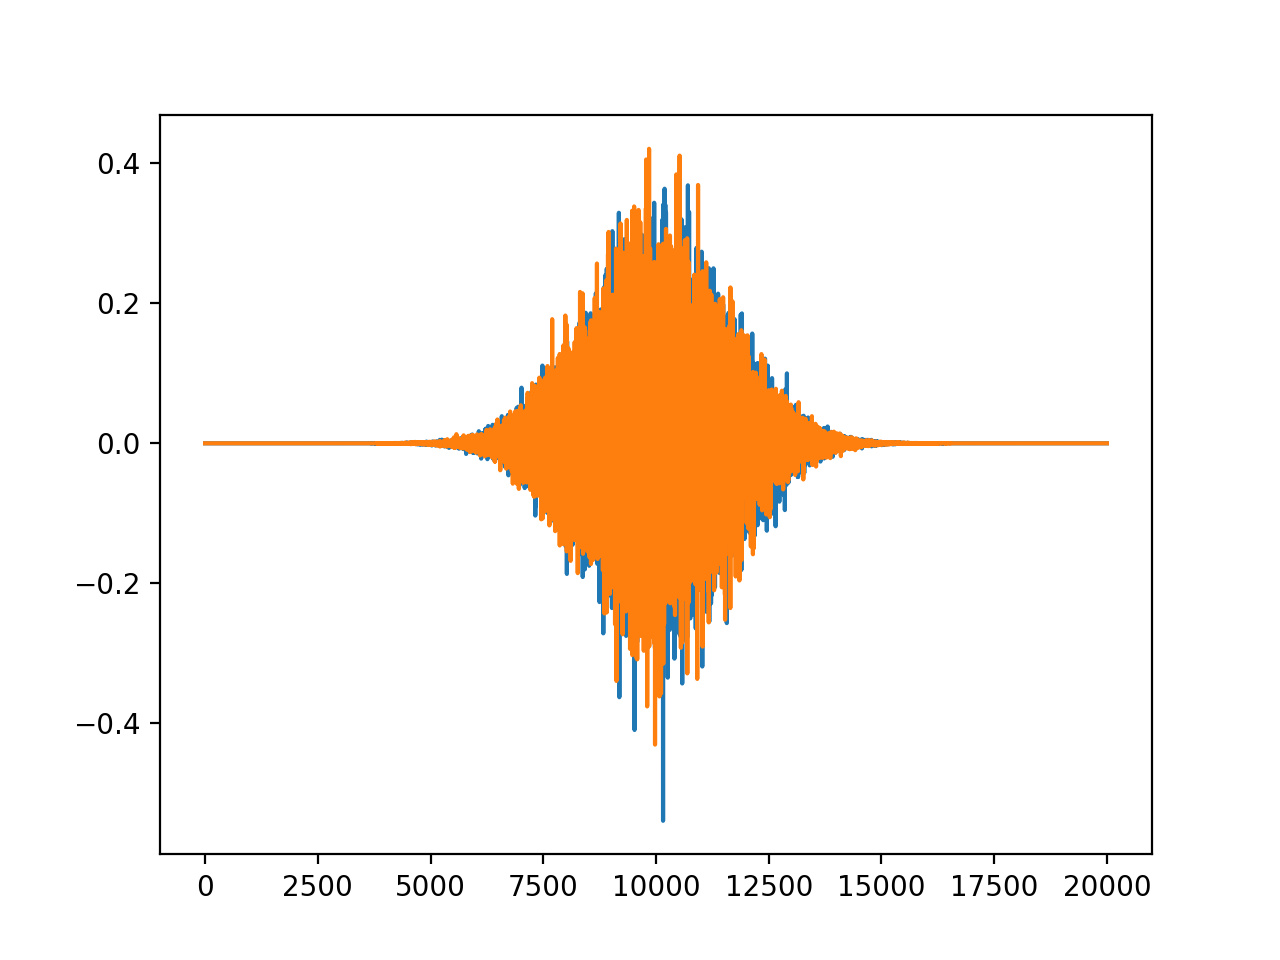

In [15]:
# Any sim should basically be able to start here.  Use gaussian noise, filter with same time width.
figure()
plot(downsampled_filtered_mixed_down_s[::100].real)
plot(downsampled_filtered_mixed_down_s[::100].imag)

In [16]:
#repeat pulse to get ~0.15 sec.
downsampled_filtered_mixed_down_s_repeated = np.tile(downsampled_filtered_mixed_down_s, 30)

In [17]:
# Check how long dispersion actually is, need to have significantly longer than this worth of data to not worry.
t_delay = 4.15e15 * (1/(1.2e9)**2 - 1/(1.6e9)**2) * 35
#const * (1/freq_low^2(Hz) - 1/(freq_high(Hz))^2) * DM #ans in s
print(t_delay)

0.04412977430555556


In [18]:
#disperse:
#Create convolution in fourier space.
#this needs to be long relative to dispersion delay time.  
length = len(downsampled_filtered_mixed_down_s_repeated)
f = np.linspace(-Fbw/2,Fbw/2,length)
DM = 35
H =  np.exp(2j*np.pi*4.148808e15*DM*f**2/((Flo+f)*Flo**2))  #freq in Hz, +/- around flo

In [19]:
dispersed_downsampled_filtered_mixed_down_s = np.fft.ifft(np.fft.fft(downsampled_filtered_mixed_down_s_repeated)*H)

<IPython.core.display.Javascript object>


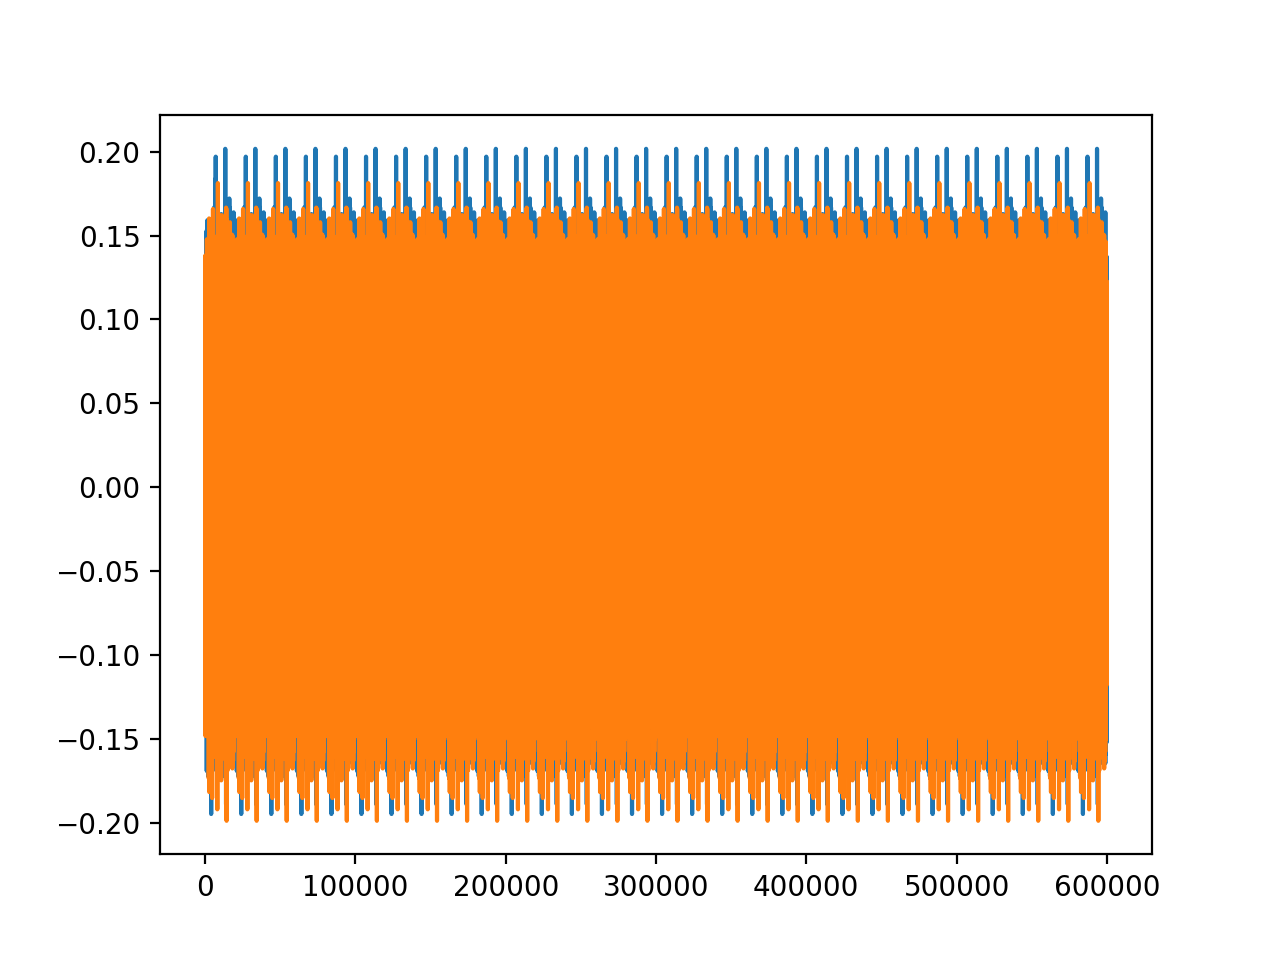

In [20]:
figure()
plot(dispersed_downsampled_filtered_mixed_down_s[::100].real)
plot(dispersed_downsampled_filtered_mixed_down_s[::100].imag)

In [21]:
#close('all')

In [22]:
#integrate to 0.1ms, 100khz resolution?
print(len(dispersed_downsampled_filtered_mixed_down_s)/4000)

15000.0


In [23]:
#400msps complex
1/400e6

2.5e-09

In [24]:
#want 0.1ms integrations
1e-4/(1/400e6)/4000

10.0

In [25]:
#integrate 10 samples
step = 4000
int_size = 10
n_spectra = 1500
spec_out = np.zeros((n_spectra,step), dtype=complex)
for i in range(n_spectra):
    for j in range(int_size):
        spec = np.fft.fft(dispersed_downsampled_filtered_mixed_down_s[(int_size*i+j)*step:(int_size*i+j+1)*step])
        spec_out[i] += spec*spec.conjugate()

In [26]:
spec_out.shape

(1500, 4000)

<IPython.core.display.Javascript object>


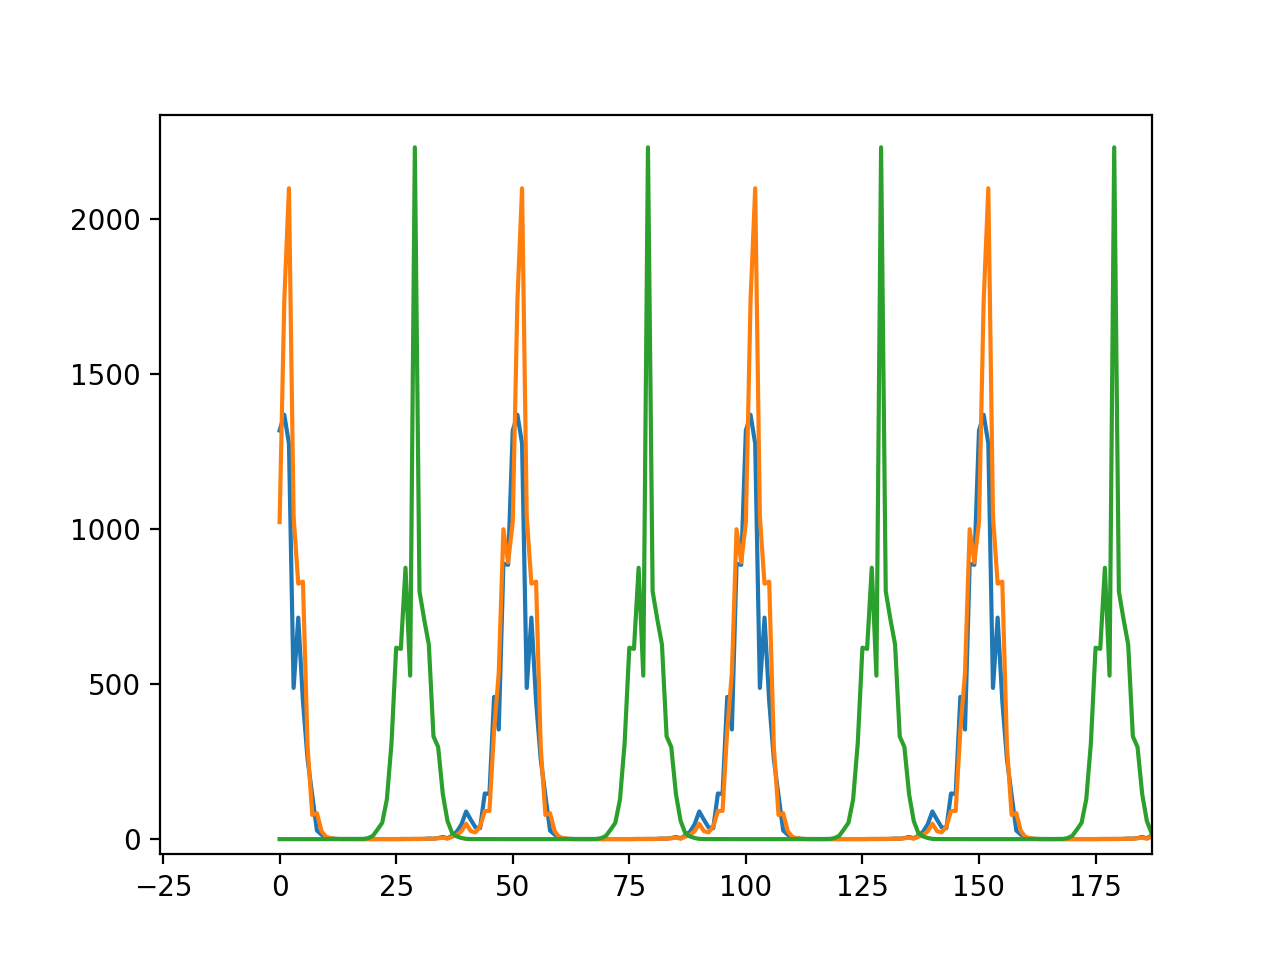

In [27]:
figure()
plot(spec_out[:,3999].real)
plot(spec_out[:,3998].real)
plot(spec_out[:,3000].real)

<IPython.core.display.Javascript object>


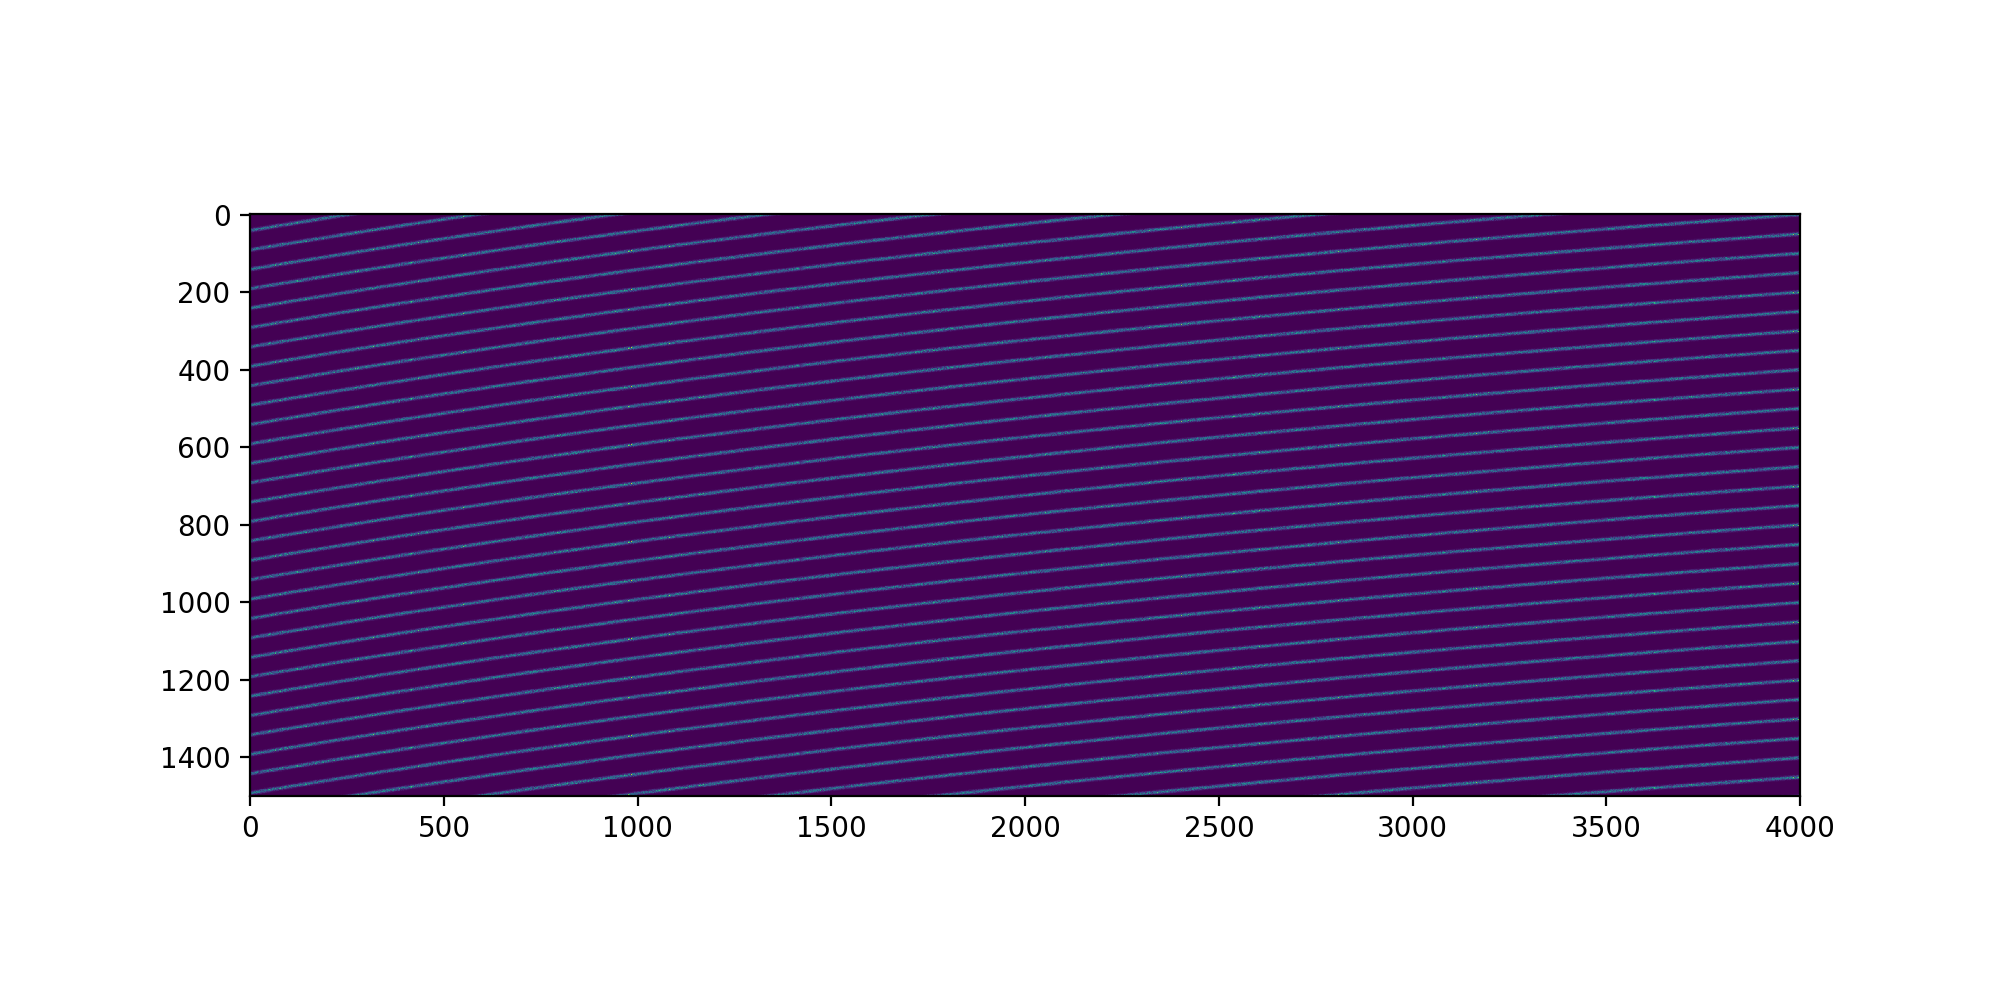

In [28]:
figure(figsize=(10,5))
imshow(spec_out.real)
# this is naturally top first time, bottom last time, lowest freq on left, highest on right.  
#  can see sweeping pulses starting top right, down to bottom left.  

In [29]:
len(dispersed_downsampled_filtered_mixed_down_s)

60000000

In [30]:
dispersed_downsampled_filtered_mixed_down_s.dtype

dtype('complex128')

In [31]:
dispersed_downsampled_filtered_mixed_down_s.real.max()

0.2297214206264525

In [32]:
dispersed_downsampled_filtered_mixed_down_s.imag.max()

0.2465214679428562

In [33]:
2**15-2

32766

In [34]:
dispersed_downsampled_filtered_mixed_down_s = dispersed_downsampled_filtered_mixed_down_s*32766/0.26913722058904677

In [35]:
dispersed_downsampled_filtered_mixed_down_s.imag.max()

30012.654514811325

In [36]:
dispersed_downsampled_filtered_mixed_down_s_real = dispersed_downsampled_filtered_mixed_down_s.real.astype(np.int16)
dispersed_downsampled_filtered_mixed_down_s_imag = dispersed_downsampled_filtered_mixed_down_s.imag.astype(np.int16)

In [37]:
dispersed_downsampled_filtered_mixed_down_s_real[:10]

array([-3270,  5988,  -374,  -709,  -636,  1157,   183,  2080, -4087,
       -2015], dtype=int16)

In [38]:
dispersed_downsampled_filtered_mixed_down_s.real[:10]

array([-3270.26292347,  5988.1592121 ,  -374.64651193,  -709.13488605,
        -636.23285071,  1157.99864066,   183.85321207,  2080.17771213,
       -4087.50717365, -2015.50043493])

In [39]:
dispersed_downsampled_filtered_mixed_down_s.real.max()

27967.339678147346

In [40]:
dispersed_downsampled_filtered_mixed_down_s_real.shape

(60000000,)

In [41]:
out = np.zeros(2*len(dispersed_downsampled_filtered_mixed_down_s_real), dtype=np.int16)

In [42]:
out[::2] = dispersed_downsampled_filtered_mixed_down_s_real
out[1::2] = dispersed_downsampled_filtered_mixed_down_s_imag

In [43]:
out[:20]

array([-3270,  -439,  5988,  6395,  -374, -1528,  -709,  5533,  -636,
       -2397,  1157,  2003,   183,  1487,  2080,  3345, -4087,  3667,
       -2015, -9960], dtype=int16)